# MLOps Assignment 3: AutoML

In [1]:
import pandas as pd
import numpy as np
from pycaret.regression import *
import matplotlib.pyplot as plt

## Load and Process Data

In [2]:
data = pd.read_csv("athletes.csv")

data.head()

,athlete_id,name,region,team,affiliate,gender,age,height,weight,fran,...,snatch,deadlift,backsq,pullups,eat,train,background,experience,schedule,howlong
0,2554.0,Pj Ablang,South West,Double Edge,Double Edge CrossFit,Male,24.0,70.0,166.0,NaN,...,NaN,400.0,305.0,NaN,NaN,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|I r...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
1,3517.0,Derek Abdella,NaN,NaN,NaN,Male,42.0,70.0,190.0,NaN,...,NaN,NaN,NaN,NaN,NaN,I have a coach who determines my programming|I...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
2,4691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5164.0,Abo Brandon,Southern California,LAX CrossFit,LAX CrossFit,Male,40.0,67.0,NaN,211.0,...,200.0,375.0,325.0,25.0,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|,4+ years|
4,5286.0,Bryce Abbey,NaN,NaN,NaN,Male,32.0,65.0,149.0,206.0,...,150.0,NaN,325.0,50.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I inc...,I played college sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I strictly s...,1-2 years|


In [3]:
# clean data and store original copy
data_cp = data.copy()

# remove not relevant columns
data_cp = data_cp.dropna(subset=['region','age','weight','height','howlong','gender','eat',
                                 'train','background','experience','schedule','howlong',
                                 'deadlift','candj','snatch','backsq','experience',
                                 'background','schedule','howlong'])
data_cp = data_cp.drop(columns=['affiliate','team','name','fran','helen','grace',
                                'filthy50','fgonebad','run400','run5k','pullups','train'])

# remove Outliers
data_cp = data_cp[data_cp['weight'] < 1500]
data_cp = data_cp[data_cp['gender'] != '--']
data_cp = data_cp[data_cp['age'] >= 18]
data_cp = data_cp[(data_cp['height'] < 96) & (data_cp['height'] > 48)]

data_cp = data_cp[
    ((data_cp['gender'] == 'Male') & (data_cp['deadlift'] > 0) & (data_cp['deadlift'] <= 1105)) |
    ((data_cp['gender'] == 'Female') & (data_cp['deadlift'] > 0) & (data_cp['deadlift'] <= 636))
]
data_cp = data_cp[(data_cp['candj'] > 0) & (data_cp['candj'] <= 395)]
data_cp = data_cp[(data_cp['snatch'] > 0) & (data_cp['snatch'] <= 496)]
data_cp = data_cp[(data_cp['backsq'] > 0) & (data_cp['backsq'] <= 1069)]

# clean Survey Data
decline_dict = {'Decline to answer|': np.nan}
data_cp = data_cp.replace(decline_dict)
data_cp = data_cp.dropna(subset=['background','experience','schedule','howlong','eat'])

In [4]:
# create new features

# calculate total lift
data_cp["total_lift"] = (data_cp["deadlift"] + data_cp["candj"] +
                         data_cp["snatch"] + data_cp["backsq"])

# create relative lift cols
data_cp['candj_rel'] = data_cp['candj'] / data_cp['weight']
data_cp['snatch_rel'] = data_cp['snatch'] / data_cp['weight']
data_cp['deadlift_rel'] = data_cp['deadlift'] / data_cp['weight']
data_cp['backsq_rel'] = data_cp['backsq'] / data_cp['weight']

# create bmi cols
data_cp['BMI'] = (data_cp['weight'] * 703) / (data_cp['height'] ** 2)

# only retain final relevant cols
data_cp = data_cp[['gender', 'age', 'height', 'weight', 'total_lift', 'candj_rel', 'snatch_rel', 'deadlift_rel', 'backsq_rel', 'BMI']]

In [5]:
data_cp.head()

,gender,age,height,weight,total_lift,candj_rel,snatch_rel,deadlift_rel,backsq_rel,BMI
21,Male,30.0,71.0,200.0,1110.0,1.175000,0.875000,1.925000,1.575000,27.891291
22,Male,28.0,70.0,176.0,910.0,1.062500,0.761364,1.903409,1.443182,25.250612
27,Male,35.0,68.0,225.0,1335.0,1.266667,0.911111,1.955556,1.800000,34.207396
50,Male,36.0,71.0,199.0,1354.0,1.341709,1.065327,2.437186,1.959799,27.751835
60,Male,36.0,64.0,155.0,1225.0,1.580645,1.161290,2.677419,2.483871,26.602783


### Target Variable: Total Lift

(Note: cleaning and new features are based on HW 2)

## AutoML: All Features

In [6]:
# initialize model setup
aml_set = setup(
    data = data_cp,
    target = 'total_lift',
    session_id = 451,
    verbose = False
)

In [10]:
# run model comparisons
# times out after 2 minutes
best_models = compare_models(n_select = 10, turbo = True, sort = 'R2', fold = 5,
                             round = 3, budget_time = 120)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,7.944,269.768,16.405,0.996,0.032,0.012,4.200
lightgbm,Light Gradient Boosting Machine,10.740,335.482,18.277,0.996,0.047,0.017,0.762
rf,Random Forest Regressor,11.447,480.299,21.862,0.994,0.042,0.017,8.296
xgboost,Extreme Gradient Boosting,13.512,459.501,21.376,0.994,0.047,0.020,0.480
gbr,Gradient Boosting Regressor,16.041,536.349,23.138,0.993,0.038,0.019,2.742
dt,Decision Tree Regressor,27.483,1608.751,40.080,0.979,0.057,0.033,0.188
lar,Least Angle Regression,27.629,3097.001,55.570,0.960,0.073,0.035,0.110
lr,Linear Regression,27.615,3093.221,55.533,0.960,0.073,0.035,0.066
ridge,Ridge Regression,27.619,3093.133,55.533,0.960,0.073,0.035,0.066
lasso,Lasso Regression,28.033,3118.994,55.777,0.960,0.072,0.035,0.134


Processing:   0%|          | 0/90 [00:00<?, ?it/s]

### Data Insights

The AutoML results show that tree-based ensemble models like Extra Trees, LightGBM, and Gradient Boosting perform best, with Extra Trees achieving the highest R² of 0.996 and the lowest errors, indicating strong nonlinear relationships in the data. Simpler linear models and basic regressors have noticeably lower accuracy and higher errors, suggesting the problem is complex and benefits from advanced models. Training times vary, with Extra Trees being slightly slower but more accurate than faster models like LightGBM or Linear Regression. Overall, the dataset appears is well-suited for ensemble methods, which capture its predictive patterns effectively.

### Top 5 Features

In [ ]:
# find best model
best_model = best_models[0]

In [15]:
 # get processed training features
X_train = get_config('X_train')
feature_names = X_train.columns

In [16]:
# get the top 5 features
importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index = feature_names)
top5 = feat_imp.sort_values(ascending = False).head(5)

print("Top 5 Features:\n", top5)

Top 5 Features:
 gender          0.511156
weight          0.123244
backsq_rel      0.103504
candj_rel       0.082911
deadlift_rel    0.070994
dtype: float64


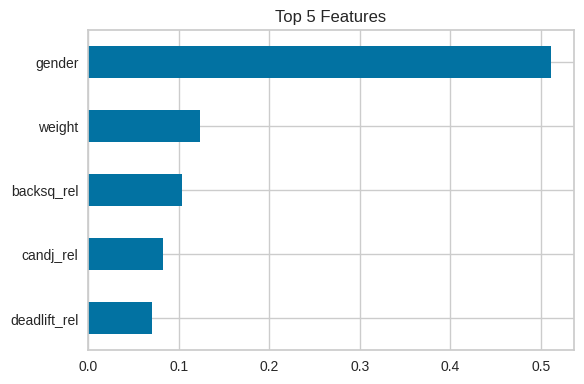

In [18]:
top5.plot(kind='barh', title='Top 5 Features', figsize=(6, 4))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

The top 5 features in order of importance are gender, weight, relative backsquat, relative candj, and relative deadlift.

## AutoML: Top 5 Features

In [19]:
# retain target + top 3 features
top3_features = ['gender', 'weight', 'backsq_rel', 'total_lift']
data_cp_top3 = data_cp[top3_features]

In [20]:
# initialize model setup
aml_set2 = setup(
    data = data_cp_top3,
    target = 'total_lift',
    session_id = 452,
    verbose = False
)

In [21]:
# run model comparisons
# times out after 2 minutes
best_models2 = compare_models(n_select = 10, turbo = True, sort = 'R2', fold = 5,
                             round = 3, budget_time = 120)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,51.445,4610.505,67.883,0.940,0.095,0.069,1.006
lightgbm,Light Gradient Boosting Machine,51.345,4592.696,67.756,0.940,0.097,0.070,0.372
xgboost,Extreme Gradient Boosting,52.479,4864.961,69.735,0.937,0.096,0.064,0.188
rf,Random Forest Regressor,55.349,5335.074,73.022,0.931,0.104,0.078,2.070
et,Extra Trees Regressor,57.219,5719.425,75.617,0.926,0.097,0.066,1.360
dt,Decision Tree Regressor,60.390,6604.956,81.238,0.914,0.118,0.091,0.126
knn,K Neighbors Regressor,60.072,6808.250,82.488,0.912,0.115,0.085,0.152
lr,Linear Regression,60.978,9200.443,93.859,0.881,0.107,0.077,1.432
ridge,Ridge Regression,60.989,9199.704,93.860,0.881,0.107,0.077,0.064
lasso,Lasso Regression,61.235,9199.156,93.945,0.881,0.107,0.077,0.064


Processing:   0%|          | 0/90 [00:00<?, ?it/s]

## Conceptual Questions

### Model Comparisons

#### Top 3 Models by Validation Score (R²)

##### Using All Features
- Extra Trees Regressor — R²: 0.996
- LightGBM — R²: 0.996
- Random Forest Regressor — R²: 0.994

##### Using Top 3 Features
- Gradient Boosting Regressor — R²: 0.940
- LightGBM — R²: 0.940
- XGBoost — R²: 0.937

---

#### Top 3 Models by Speed (Training Time)

##### Using All Features
- Ridge Regression — 0.066 sec
- Linear Regression — 0.066 sec
- Lasso Least Angle Regression — 0.104 sec

##### Using Top 3 Features
- Orthogonal Matching Pursuit — 0.056 sec
- Bayesian Ridge — 0.060 sec
- Lasso Least Angle Regression — 0.068 sec


### How do the top models compare to your previously developed model (assignments 1 and 2) in terms of validation score and speed?

The top AutoML models significantly outperform the earlier models developed in Assignment 1 and Assignment 2 in terms of validation scores. The Linear Regression model from Assignment 1 achieved a test RMSE of 177.95 and R² of 0.59, indicating moderate predictive power. In contrast, the best XGBoost regression models from Assignment 2, particularly on data version 2, achieved much lower RMSE values between 19–27 and very high R² scores between 0.99 and 0.995, showing substantial improvement in accuracy. However, the AutoML Extra Trees model achieves the highest R² of 0.996 among all models evaluated across the assignments. In terms of speed, the initial linear model from Assignment 1 ran faster due to its simplicity, but the more complex models from Assignment 2 and AutoML require slightly longer training times due to their complexity. Despite this, the advanced models provide a better balance between speed and performance, with training times still reasonable given the significant gains in predictive accuracy.


### Is your platform AutoML no-code/low-code/full-code and why?

For this assignment, I chose to use the Google Colab with PyCaret for AutoML, which is a low-code platform. The user still has to write and run code, however PyCaret automates much of the machine learning workflow with simple, high-level commands. It’s not a no-code solution since it lacks a graphical interface and requires manual scripting, but it’s far less complex than full-code approaches where you build every pipeline step from scratch.